# 1. Library Imports
<a id='li'></a>

In [309]:
import pandas as pd
import numpy as np
# from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from collections import Counter
from utils2 import *
# from utils1 import knn_imputer
import umap

### WARNINGS
import warnings
warnings.filterwarnings('ignore')

### AUTORELOAD
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Data Preparation
<a id='dp'></a>

In [310]:
demographics = pd.read_csv('Data/Final_Data/demographic_perspective.csv')
preference = pd.read_csv('Data/Final_Data/preference_perspective.csv')

In [311]:
data = pd.concat([demographics, preference], axis=1)
data

,frequency_items,potencial_score,longevity_months,relevance_criteria,recency_in_weeks,promotional_percentage,returns,flaged,credit_factor,zip_code,...,frozen_foods,fruit_beverages,pastry,sodas,toiletries,veggies,wines,mm_kmeans3,rb_dbs5,mm_dbs5
0,38,-0.40,23,2,15,20,0,0,0.7,0,...,150,105,27,24,27,10,0,2,4,3
1,50,-0.30,24,2,10,36,0,0,0.7,0,...,26,20,31,0,2,18,2,2,0,0
2,48,1.60,32,2,20,0,0,0,0.7,0,...,0,25,32,17,33,26,0,0,0,0
3,46,-0.90,12,2,14,36,0,0,4.5,0,...,66,16,29,31,28,0,8,0,0,0
4,31,31.61,10,2,12,10,0,0,0.7,8,...,57,27,45,46,19,23,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122124,51,0.10,25,2,9,0,1,0,0.7,0,...,33,39,26,27,48,54,0,0,0,0
122125,42,30.99,23,2,15,0,0,0,0.7,8,...,40,36,27,47,15,24,3,0,0,0
122126,24,79.76,29,2,13,13,0,0,0.7,8,...,41,26,25,27,23,11,0,0,0,0
122127,29,0.50,14,2,11,0,0,0,0.7,0,...,21,27,27,10,4,34,0,0,0,0


In [312]:
data.rename(columns={'mm_kmeans5': 'd_mm_kmeans5', 'mm_ward5': 'd_mm_ward5', 'mm_kmeans3': 'p_mm_kmeans3', 'mm_dbs5': 'p_mm_dbs5'}, inplace=True)
data.drop(columns=['rb_dbs5'], inplace=True)

In [313]:
preference_metrics = ['beer', 'bottled_water', 'bread', 'meat', 'dairy', 'fresh_foods', 'frozen_foods', 'fruit_beverages', 'pastry', 'sodas', 'toiletries', 'veggies', 'wines']
preference_metrics_selected = ['beer', 'bottled_water', 'bread', 'dairy', 'fresh_foods', 'frozen_foods', 'fruit_beverages', 'pastry', 'sodas', 'toiletries', 'veggies', 'wines']
preference_lables = ['p_mm_kmeans3', 'p_mm_dbs5']

demographic_metrics = ['frequency_items', 'potencial_score', 'longevity_months', 'relevance_criteria', 'recency_in_weeks', 'promotional_percentage', 'returns', 'flaged', 'credit_factor', 'zip_code', 'education', 'gender']
demographic_metrics_selected = ['frequency_items', 'potencial_score', 'longevity_months', 'relevance_criteria', 'recency_in_weeks', 'promotional_percentage', 'returns', 'flaged']
demographic_lables = ['d_mm_kmeans5', 'd_mm_ward5']

metrics = preference_metrics + demographic_metrics
metrics_selected = preference_metrics_selected + demographic_metrics_selected
labels = preference_lables + demographic_lables


In [314]:
data_original = data.copy()

data_l = data[metrics + labels]
data_selected_l = data[metrics_selected + labels]

data = data[metrics]
data_selected = data[metrics_selected]

#### Scale the data

In [315]:
# Defining the scalers
minmax = MinMaxScaler()

In [316]:
# Scaling the data
dt_mm_scl = minmax.fit_transform(data_selected)

In [317]:
# Creating the scaled dataframes
data_mm_scl = data_selected.copy()
data_mm_scl[metrics_selected] = dt_mm_scl

In [12]:
# # Creating equal samples of the differently scaled dataframes
# sample_original = data.sample(frac=0.2, random_state=1)
# sample_mm_scl = data_mm_scl.sample(frac=0.2, random_state=1)
# sample_rb_scl = data_rb_scl.sample(frac=0.2, random_state=1)

In [13]:
umap_object = umap.UMAP(random_state=1)
umap_embedding_mm = umap_object.fit_transform(data_mm_scl[metrics_selected])

In [318]:
data_mm_scl[labels] = data_selected_l[labels]

# Merge Perspectives

In [319]:
## Map combinations of the two labels to their merged cluster label

def hc_merge_mapper(df, label1, label2, feats, merged_label, n_clusters=1):
  """
  merged_label  : what to call the column that should contain the merged label
  n_clusters    : how many clusters to keep
  """
  df_ = df.copy()

  # Centroids of the concatenated cluster labels
  df_centroids = df_.groupby([label1, label2])[feats].mean()

  # Re-running the Hierarchical clustering based on the correct number of clusters
  hclust = AgglomerativeClustering(
      linkage='ward',
      metric='euclidean',
      n_clusters=n_clusters
  )
  hclust_labels = hclust.fit_predict(df_centroids)
  df_centroids[merged_label] = hclust_labels

  cluster_mapper = df_centroids[merged_label].to_dict()

  # Mapping the clusters on the centroids to the observations
  df_[merged_label] = df_.apply(
      lambda row: cluster_mapper[
          (row[label1], row[label2])
      ], axis=1
  )

  return df_, df_centroids


def make_contingency_table(df, label1, label2):
  df_ = df.groupby([label1, label2])\
            .size()\
            .to_frame()\
            .reset_index()\
            .pivot(index=label2, columns=label1)
  df_.columns = df_.columns.droplevel()
  return df_

# P: Kmeans 3 + D: Kmeans 5

In [320]:
make_contingency_table(data_selected_l, 'p_mm_kmeans3', 'd_mm_kmeans5')

p_mm_kmeans3,0,1,2
d_mm_kmeans5,,,
0,8087,8452,9462
1,15787,15890,17654
2,1828,1814,2006
3,11471,11656,12858
4,1518,1720,1926


In [321]:
df_hc_centroids = data_mm_scl.groupby(['p_mm_kmeans3', 'd_mm_kmeans5'])[metrics_selected].mean()
df_hc_centroids

beer  bottled_water     bread     dairy  \
p_mm_kmeans3 d_mm_kmeans5                                                
0            0             0.045752       0.141113  0.039413  0.071208   
             1             0.044783       0.139400  0.038737  0.069703   
             2             0.044780       0.141316  0.038487  0.069280   
             3             0.045210       0.140310  0.038046  0.070383   
             4             0.054070       0.138492  0.045718  0.081972   
1            0             0.142949       0.455202  0.056822  0.015913   
             1             0.141030       0.452714  0.054968  0.013861   
             2             0.141309       0.456467  0.054876  0.013809   
             3             0.141184       0.453817  0.054498  0.013989   
             4             0.156000       0.458024  0.064012  0.026478   
2            0             0.048630       0.141612  0.057887  0.019016   
             1             0.046148       0.139766  0.055369  0.014285   
             2             0.046379       0.142315  0.055290  0.014313   
             3             0.046037       0.140297  0.054900  0.014740   
             4             0.067307       0.142066  0.072375  0.035450   

                           fresh_foods  frozen_foods  fruit_beverages  \
p_mm_kmeans3 d_mm_kmeans5                                               
0            0                0.061046      0.036452         0.040134   
             1                0.057524      0.033368         0.038821   
             2                0.058127      0.035230         0.040504   
             3                0.057882      0.033639         0.038731   
             4                0.065406      0.043194         0.043629   
1            0                0.065218      0.118695         0.042173   
             1                0.058641      0.113086         0.039752   
             2                0.059928      0.115245         0.040400   
             3                0.059146      0.113542         0.039681   
             4                0.078271      0.124837         0.050679   
2            0                0.202287      0.072670         0.184509   
             1                0.193466      0.065363         0.182377   
             2                0.194920      0.067978         0.182722   
             3                0.193379      0.066851         0.182094   
             4                0.217745      0.083978         0.199359   

                             pastry     sodas  toiletries   veggies     wines  \
p_mm_kmeans3 d_mm_kmeans5                                                       
0            0             0.080501  0.025089    0.170285  0.052136  0.156192   
             1             0.075934  0.023286    0.168268  0.050372  0.150032   
             2             0.078423  0.022526    0.170074  0.048376  0.161103   
             3             0.078893  0.023465    0.169081  0.050714  0.155562   
             4             0.098010  0.038163    0.181743  0.064531  0.163299   
1            0             0.028270  0.026317    0.179522  0.039654  0.135003   
             1             0.025081  0.023368    0.175630  0.035172  0.133834   
             2             0.026152  0.023182    0.180801  0.038184  0.145014   
             3             0.026870  0.023687    0.176816  0.037080  0.135617   
             4             0.048183  0.041511    0.192886  0.058664  0.135957   
2            0             0.095477  0.027476    0.157470  0.041119  0.062740   
             1             0.092625  0.023310    0.155024  0.037666  0.060066   
             2             0.092650  0.024062    0.158673  0.040144  0.068048   
             3             0.094806  0.024225    0.153383  0.038179  0.060808   
             4             0.114906  0.044134    0.170606  0.060207  0.065243   

                           frequency_items  potencial_score  longevity_months  \
p_mm_kmeans3 d_mm_kmeans5                                              

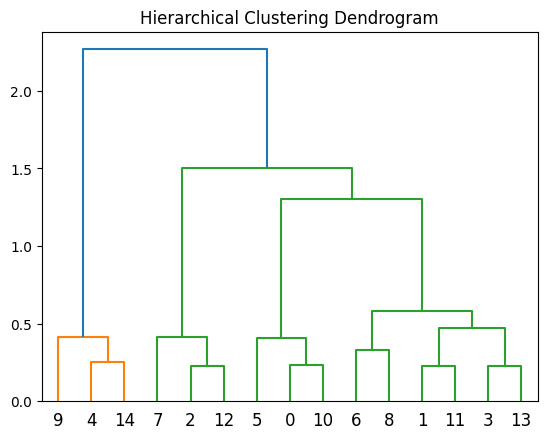

In [322]:
plot_dendrogram(df_hc_centroids, 'ward')

In [323]:
df_hc_merged, df_hc_centroids = hc_merge_mapper(data_mm_scl, 'p_mm_kmeans3', 'd_mm_kmeans5', metrics_selected, 'hc_merged_labels', 5)

In [324]:
df_hc_centroids

beer  bottled_water     bread     dairy  \
p_mm_kmeans3 d_mm_kmeans5                                                
0            0             0.045752       0.141113  0.039413  0.071208   
             1             0.044783       0.139400  0.038737  0.069703   
             2             0.044780       0.141316  0.038487  0.069280   
             3             0.045210       0.140310  0.038046  0.070383   
             4             0.054070       0.138492  0.045718  0.081972   
1            0             0.142949       0.455202  0.056822  0.015913   
             1             0.141030       0.452714  0.054968  0.013861   
             2             0.141309       0.456467  0.054876  0.013809   
             3             0.141184       0.453817  0.054498  0.013989   
             4             0.156000       0.458024  0.064012  0.026478   
2            0             0.048630       0.141612  0.057887  0.019016   
             1             0.046148       0.139766  0.055369  0.014285   
             2             0.046379       0.142315  0.055290  0.014313   
             3             0.046037       0.140297  0.054900  0.014740   
             4             0.067307       0.142066  0.072375  0.035450   

                           fresh_foods  frozen_foods  fruit_beverages  \
p_mm_kmeans3 d_mm_kmeans5                                               
0            0                0.061046      0.036452         0.040134   
             1                0.057524      0.033368         0.038821   
             2                0.058127      0.035230         0.040504   
             3                0.057882      0.033639         0.038731   
             4                0.065406      0.043194         0.043629   
1            0                0.065218      0.118695         0.042173   
             1                0.058641      0.113086         0.039752   
             2                0.059928      0.115245         0.040400   
             3                0.059146      0.113542         0.039681   
             4                0.078271      0.124837         0.050679   
2            0                0.202287      0.072670         0.184509   
             1                0.193466      0.065363         0.182377   
             2                0.194920      0.067978         0.182722   
             3                0.193379      0.066851         0.182094   
             4                0.217745      0.083978         0.199359   

                             pastry     sodas  toiletries  ...     wines  \
p_mm_kmeans3 d_mm_kmeans5                                  ...             
0            0             0.080501  0.025089    0.170285  ...  0.156192   
             1             0.075934  0.023286    0.168268  ...  0.150032   
             2             0.078423  0.022526    0.170074  ...  0.161103   
             3             0.078893  0.023465    0.169081  ...  0.155562   
             4             0.098010  0.038163    0.181743  ...  0.163299   
1            0             0.028270  0.026317    0.179522  ...  0.135003   
             1             0.025081  0.023368    0.175630  ...  0.133834   
             2             0.026152  0.023182    0.180801  ...  0.145014   
             3             0.026870  0.023687    0.176816  ...  0.135617   
             4             0.048183  0.041511    0.192886  ...  0.135957   
2            0             0.095477  0.027476    0.157470  ...  0.062740   
             1             0.092625  0.023310    0.155024  ...  0.060066   
             2             0.092650  0.024062    0.158673  ...  0.068048   
             3             0.094806  0.024225    0.153383  ...  0.060808   
             4             0.114906  0.044134    0.170606  ...  0.065243   

                           frequency_items  potencial_score  longevity_months  \
p_mm_kmeans3 d_mm_kmeans5                                                       
0            0                    0.305403         0.803503          0.3650

In [325]:
df_hc_centroids[['hc_merged_labels']].reset_index()

,p_mm_kmeans3,d_mm_kmeans5,hc_merged_labels
0,0,0,3
1,0,1,0
2,0,2,2
3,0,3,0
4,0,4,1
5,1,0,3
6,1,1,4
7,1,2,2
8,1,3,4
9,1,4,1


In [326]:
data['hc_k3_k5'] = df_hc_merged['hc_merged_labels']

In [327]:
groupby_mean(data, 'hc_k3_k5', True, 25, ax = 1)

# observations per cluster: [57770, 5164, 5648, 26001, 27546]


hc_k3_k5,0,1,2,3,4
beer,45.540000,64.830000,58.070000,58.910000,84.430000
bottled_water,44.630000,58.030000,57.600000,57.670000,84.100000
bread,26.400000,33.570000,27.610000,28.640000,30.110000
meat,1.100000,12.620000,1.100000,4.150000,1.050000
dairy,52.350000,56.830000,45.190000,47.080000,30.410000
fresh_foods,71.930000,70.340000,59.650000,63.270000,32.720000
frozen_foods,49.180000,83.120000,70.460000,74.150000,109.990000
fruit_beverages,60.030000,54.530000,47.670000,48.910000,20.810000
pastry,58.740000,59.610000,49.880000,50.930000,30.960000
sodas,33.020000,58.230000,32.660000,36.980000,32.970000


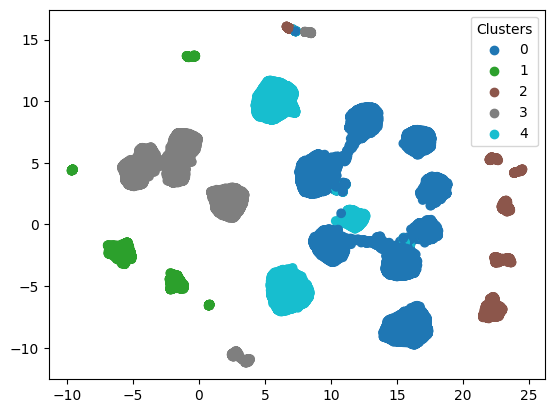

In [328]:
visualize_dimensionality_reduction(umap_embedding_mm, data['hc_k3_k5'])

# P: Kmeans 3 + D: Ward 5

In [329]:
make_contingency_table(data_selected_l, 'p_mm_kmeans3', 'd_mm_ward5')

p_mm_kmeans3,0,1,2
d_mm_ward5,,,
0,11636,11892,13037
1,2328,2406,2687
2,7686,8008,8959
3,1437,1595,1769
4,15604,15631,17454


In [330]:
df_hc_centroids = data_mm_scl.groupby(['p_mm_kmeans3', 'd_mm_ward5'])[metrics_selected].mean()
df_hc_centroids

beer  bottled_water     bread     dairy  \
p_mm_kmeans3 d_mm_ward5                                                
0            0           0.044625       0.140205  0.038116  0.070009   
             1           0.046765       0.142363  0.038896  0.070686   
             2           0.045451       0.140956  0.039397  0.070972   
             3           0.053507       0.137257  0.045946  0.082290   
             4           0.045191       0.139481  0.038680  0.069967   
1            0           0.140502       0.454206  0.054378  0.013875   
             1           0.145673       0.459631  0.056754  0.015306   
             2           0.142157       0.455037  0.056557  0.015704   
             3           0.155381       0.453754  0.063859  0.026835   
             4           0.141508       0.452405  0.055057  0.013947   
2            0           0.045314       0.140253  0.054524  0.014276   
             1           0.051045       0.143906  0.058224  0.017588   
             2           0.048118       0.141382  0.057605  0.018607   
             3           0.065718       0.140605  0.071597  0.035822   
             4           0.046648       0.139788  0.055656  0.014620   

                         fresh_foods  frozen_foods  fruit_beverages    pastry  \
p_mm_kmeans3 d_mm_ward5                                                         
0            0              0.057530      0.033198         0.038540  0.078307   
             1              0.060070      0.036675         0.040462  0.083990   
             2              0.060891      0.036188         0.040092  0.080197   
             3              0.064484      0.043092         0.043983  0.093163   
             4              0.057766      0.033688         0.038964  0.076258   
1            0              0.058456      0.112938         0.039314  0.026727   
             1              0.066565      0.116903         0.042752  0.033305   
             2              0.064708      0.118505         0.041924  0.027725   
             3              0.074449      0.125138         0.049782  0.042877   
             4              0.059083      0.113521         0.040021  0.025116   
2            0              0.192964      0.066291         0.181564  0.094932   
             1              0.206487      0.072250         0.185156  0.099257   
             2              0.200912      0.072021         0.184409  0.094840   
             3              0.212120      0.083447         0.198043  0.111125   
             4              0.193689      0.065771         0.182787  0.092484   

                            sodas  toiletries   veggies     wines  \
p_mm_kmeans3 d_mm_ward5                                             
0            0           0.023687    0.168776  0.051071  0.154365   
             1           0.025621    0.173027  0.053678  0.157913   
             2           0.024642    0.169814  0.051694  0.156922   
             3           0.037406    0.179803  0.060464  0.164100   
             4           0.023095    0.168521  0.050086  0.150781   
1            0           0.023679    0.176324  0.036457  0.134961   
             1           0.027542    0.185909  0.049775  0.141523   
             2           0.025840    0.178853  0.038629  0.135236   
             3           0.039810    0.189061  0.049416  0.136489   
             4           0.023352    0.175985  0.035502  0.134296   
2            0           0.023768    0.153933  0.037765  0.060745   
             1           0.028814    0.162801  0.051784  0.066989   
             2           0.026892    0.156757  0.040161  0.062632   
             3           0.042828    0.168283  0.050376  0.065475   
             4           0.023621    0.154665  0.037872  0.060113   

                         frequency_items  potencial_score  longevity_months  \
p_mm_kmeans3 d_mm_ward5                                                       
0            0                  0.278962         0.219926          0.449589   
             1 

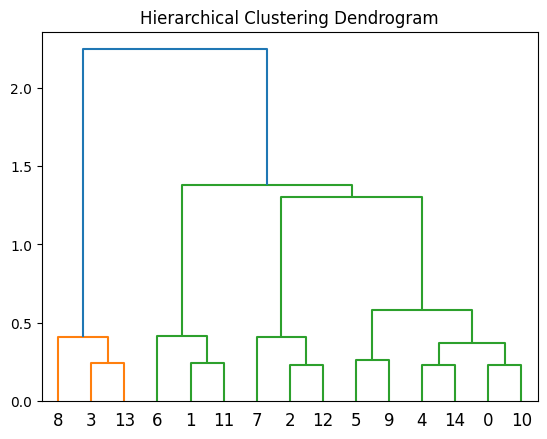

In [331]:
plot_dendrogram(df_hc_centroids, 'ward')

In [332]:
df_hc_merged, df_hc_centroids = hc_merge_mapper(data_mm_scl, 'p_mm_kmeans3', 'd_mm_ward5', metrics_selected, 'hc_merged_labels', 5)

In [333]:
df_hc_centroids[['hc_merged_labels']].reset_index()

,p_mm_kmeans3,d_mm_ward5,hc_merged_labels
0,0,0,2
1,0,1,0
2,0,2,3
3,0,3,1
4,0,4,2
5,1,0,4
6,1,1,0
7,1,2,3
8,1,3,1
9,1,4,4


In [334]:
data['hc_k3_w5'] = df_hc_merged['hc_merged_labels']

In [335]:
groupby_mean(data, 'hc_k3_w5', True, 25, ax = 1)

# observations per cluster: [7421, 4801, 57731, 24653, 27523]


hc_k3_w5,0,1,2,3,4
beer,59.720000,64.380000,45.540000,58.680000,84.420000
bottled_water,57.970000,57.700000,44.630000,57.630000,84.100000
bread,28.580000,33.370000,26.400000,28.540000,30.110000
meat,3.140000,12.790000,1.100000,3.850000,1.040000
dairy,46.470000,57.330000,52.350000,46.870000,30.410000
fresh_foods,64.050000,67.940000,71.910000,62.840000,32.700000
frozen_foods,73.380000,82.750000,49.180000,73.750000,109.980000
fruit_beverages,49.040000,53.800000,60.030000,48.800000,20.810000
pastry,52.840000,57.460000,58.720000,50.700000,30.950000
sodas,38.440000,56.400000,33.010000,36.270000,32.960000


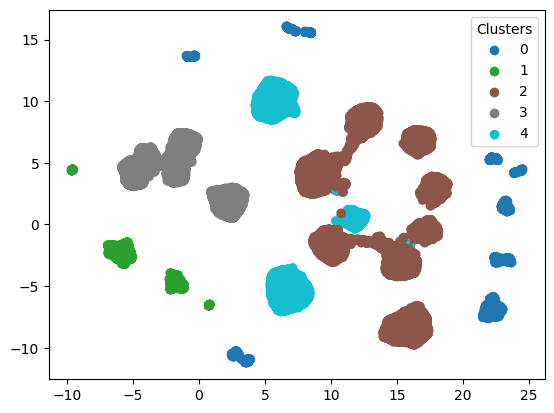

In [336]:
visualize_dimensionality_reduction(umap_embedding_mm, data['hc_k3_w5'])

# P: DBScan 5 + D: Kmeans 5

In [337]:
make_contingency_table(data_selected_l, 'p_mm_dbs5', 'd_mm_kmeans5')

p_mm_dbs5,0,1,2,3,4
d_mm_kmeans5,,,,,
0,5550,2514,3514,5965,8458
1,10990,4657,6627,10976,16081
2,1243,554,749,1282,1820
3,7956,3502,4895,7948,11684
4,1011,574,764,1190,1625


In [338]:
df_hc_centroids = data_mm_scl.groupby(['p_mm_dbs5', 'd_mm_kmeans5'])[metrics_selected].mean()
df_hc_centroids

beer  bottled_water     bread     dairy  \
p_mm_dbs5 d_mm_kmeans5                                                
0         0             0.046036       0.142810  0.031851  0.081532   
          1             0.044761       0.140161  0.031749  0.078887   
          2             0.044568       0.141427  0.030453  0.078952   
          3             0.045425       0.140781  0.030931  0.079355   
          4             0.058647       0.146350  0.041267  0.103393   
1         0             0.045829       0.145304  0.056105  0.051979   
          1             0.044978       0.140301  0.054580  0.050569   
          2             0.045193       0.142900  0.054188  0.050621   
          3             0.045438       0.142964  0.053935  0.051103   
          4             0.058985       0.175101  0.053725  0.055998   
2         0             0.046680       0.142105  0.055796  0.015104   
          1             0.045592       0.139906  0.054856  0.013564   
          2             0.046030       0.144245  0.054950  0.014048   
          3             0.045358       0.141151  0.054552  0.013855   
          4             0.057978       0.146306  0.063472  0.020124   
3         0             0.051266       0.148178  0.059489  0.020421   
          1             0.046937       0.141508  0.055929  0.014606   
          2             0.048197       0.146076  0.055940  0.014585   
          3             0.046757       0.141987  0.055371  0.015017   
          4             0.074765       0.162852  0.080560  0.040521   
4         0             0.141617       0.447783  0.056513  0.015633   
          1             0.139540       0.446965  0.054845  0.013691   
          2             0.139851       0.451413  0.054981  0.013738   
          3             0.140534       0.450442  0.054388  0.013904   
          4             0.156072       0.441607  0.062754  0.023375   

                        fresh_foods  frozen_foods  fruit_beverages    pastry  \
p_mm_dbs5 d_mm_kmeans5                                                         
0         0                0.061857      0.033965         0.040730  0.025579   
          1                0.057733      0.031930         0.038889  0.024389   
          2                0.057035      0.033606         0.038691  0.024667   
          3                0.057857      0.032642         0.038610  0.025411   
          4                0.071567      0.041368         0.047387  0.030515   
1         0                0.059758      0.034876         0.039329  0.208502   
          1                0.057807      0.031969         0.038542  0.203372   
          2                0.056538      0.033668         0.039918  0.203706   
          3                0.057871      0.033008         0.038518  0.204616   
          4                0.063304      0.045192         0.042267  0.248674   
2         0                0.200343      0.034534         0.183633  0.206670   
          1                0.193509      0.032407         0.182426  0.203185   
          2                0.195589      0.034452         0.182098  0.204494   
          3                0.193079      0.032753         0.182055  0.204441   
          4                0.213466      0.043490         0.186421  0.235814   
3         0                0.206500      0.094642         0.186184  0.027972   
          1                0.194483      0.084951         0.183903  0.024752   
          2                0.197194      0.088407         0.183748  0.026258   
          3                0.194636      0.087902         0.183232  0.026352   
          4                0.225326      0.109255         0.207860  0.036316   
4         0                0.062618      0.121013         0.040912  0.027681   
          1                0.058122      0.113839         0.039169  0.024824   
          2                0.057395      0.115523         0.039398  0.025444   
          3                0.058609      0.114227         0.039251  0.026385   
          4                0.0

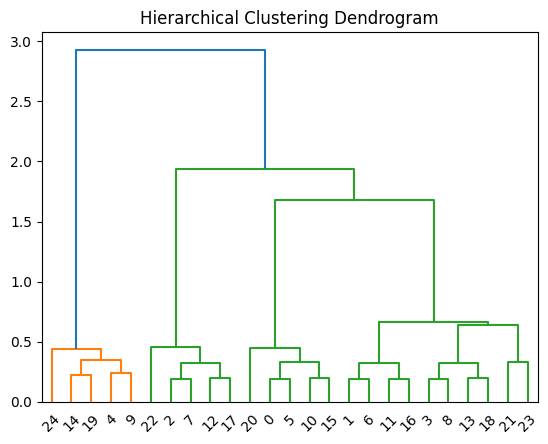

In [339]:
plot_dendrogram(df_hc_centroids, 'ward')

In [340]:
df_hc_merged, df_hc_centroids = hc_merge_mapper(data_mm_scl, 'p_mm_dbs5', 'd_mm_kmeans5', metrics_selected, 'hc_merged_labels', 5)

In [341]:
df_hc_centroids[['hc_merged_labels']].reset_index()

,p_mm_dbs5,d_mm_kmeans5,hc_merged_labels
0,0,0,1
1,0,1,4
2,0,2,2
3,0,3,0
4,0,4,3
5,1,0,1
6,1,1,4
7,1,2,2
8,1,3,0
9,1,4,3


In [342]:
data['hc_d5_k5'] = df_hc_merged['hc_merged_labels']

In [343]:
groupby_mean(data, 'hc_d5_k5', True, 25, ax = 1)

# observations per cluster: [52066, 26001, 5648, 5164, 33250]


hc_d5_k5,0,1,2,3,4
beer,66.090000,58.910000,58.070000,64.830000,45.590000
bottled_water,65.460000,57.670000,57.600000,58.030000,44.710000
bread,28.280000,28.640000,27.610000,33.570000,26.530000
meat,1.090000,4.150000,1.100000,12.620000,1.070000
dairy,40.740000,47.080000,45.190000,56.830000,52.360000
fresh_foods,50.990000,63.270000,59.650000,70.340000,72.250000
frozen_foods,82.050000,74.150000,70.460000,83.120000,48.100000
fruit_beverages,39.030000,48.910000,47.670000,54.530000,60.430000
pastry,44.220000,50.930000,49.880000,59.610000,58.450000
sodas,33.190000,36.980000,32.660000,58.230000,32.720000


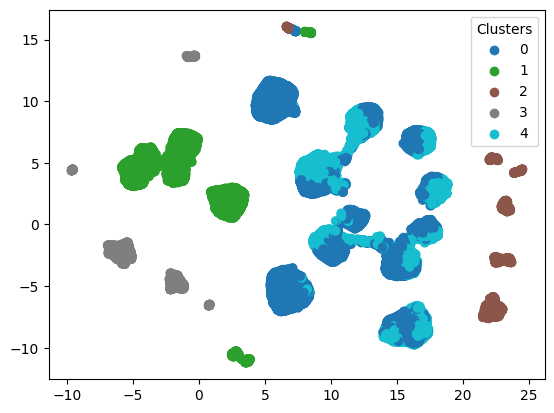

In [344]:
visualize_dimensionality_reduction(umap_embedding_mm, data['hc_d5_k5'])

# P: DBScan 5 + D: Ward 5

In [345]:
make_contingency_table(data_selected_l, 'p_mm_dbs5', 'd_mm_ward5')

p_mm_dbs5,0,1,2,3,4
d_mm_ward5,,,,,
0,8095,3523,4985,8037,11925
1,1563,752,1027,1713,2366
2,5280,2384,3321,5652,8016
3,969,517,684,1090,1541
4,10843,4625,6532,10869,15820


In [346]:
df_hc_centroids = data_mm_scl.groupby(['p_mm_dbs5', 'd_mm_ward5'])[metrics_selected].mean()
df_hc_centroids

beer  bottled_water     bread     dairy  \
p_mm_dbs5 d_mm_ward5                                                
0         0           0.044734       0.141082  0.031068  0.078987   
          1           0.046156       0.144050  0.030843  0.080011   
          2           0.045829       0.142505  0.031873  0.081391   
          3           0.058547       0.144503  0.041511  0.104240   
          4           0.045241       0.139917  0.031646  0.079155   
1         0           0.044994       0.142535  0.053863  0.050421   
          1           0.049529       0.154551  0.053949  0.051318   
          2           0.045571       0.144345  0.056081  0.051849   
          3           0.056292       0.166728  0.054561  0.056765   
          4           0.045231       0.140609  0.054645  0.051058   
2         0           0.044894       0.141609  0.054278  0.013703   
          1           0.050293       0.148344  0.056904  0.015131   
          2           0.046390       0.141839  0.055627  0.015020   
          3           0.054755       0.141418  0.062691  0.019908   
          4           0.045929       0.139501  0.055059  0.013677   
3         0           0.045776       0.141609  0.054922  0.014495   
          1           0.054714       0.154593  0.060797  0.019096   
          2           0.050632       0.147321  0.058817  0.019823   
          3           0.072035       0.156786  0.079598  0.040671   
          4           0.047571       0.141703  0.056275  0.014980   
4         0           0.139919       0.450574  0.054320  0.013744   
          1           0.144443       0.450308  0.055868  0.015529   
          2           0.140714       0.448318  0.056467  0.015304   
          3           0.155206       0.438583  0.062595  0.023437   
          4           0.139979       0.446842  0.054893  0.013805   

                      fresh_foods  frozen_foods  fruit_beverages    pastry  \
p_mm_dbs5 d_mm_ward5                                                         
0         0              0.057509      0.032289         0.038357  0.025357   
          1              0.059288      0.034241         0.039103  0.025213   
          2              0.061758      0.033872         0.040725  0.025560   
          3              0.070608      0.041316         0.047722  0.030275   
          4              0.057977      0.032180         0.039080  0.024414   
1         0              0.057760      0.032512         0.038216  0.204479   
          1              0.059508      0.036159         0.039655  0.220423   
          2              0.059478      0.034785         0.039234  0.207424   
          3              0.062296      0.043587         0.043118  0.237589   
          4              0.057842      0.032335         0.038778  0.203235   
2         0              0.192941      0.032499         0.181495  0.204603   
          1              0.205570      0.036856         0.181963  0.216372   
          2              0.199341      0.034325         0.183738  0.205624   
          3              0.207416      0.042175         0.187073  0.228067   
          4              0.193553      0.032574         0.182857  0.202966   
3         0              0.193971      0.087103         0.182753  0.026021   
          1              0.211743      0.094625         0.187586  0.028672   
          2              0.204613      0.093670         0.185867  0.027719   
          3              0.219023      0.107953         0.206023  0.035554   
          4              0.194816      0.085540         0.184299  0.024950   
4         0              0.057901      0.113678         0.038939  0.026157   
          1              0.060683      0.118398         0.040331  0.027840   
          2              0.062350      0.120656         0.040758  0.027331   
          3              0.068408      0.129819         0.046650  0.033694   
          4              0.058638      0.114229         0.039397  0.024975   

                         sodas  toiletries   veggies   

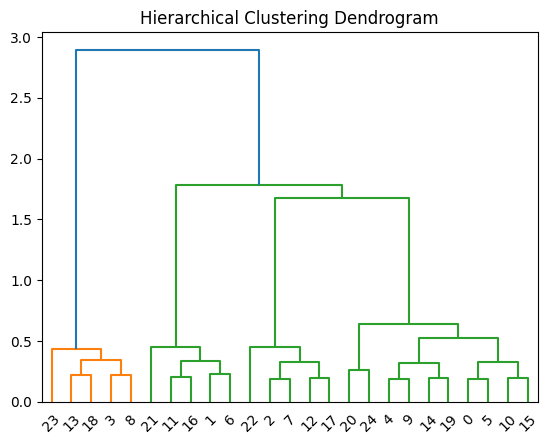

In [347]:
plot_dendrogram(df_hc_centroids, 'ward')

In [348]:
df_hc_merged, df_hc_centroids = hc_merge_mapper(data_mm_scl, 'p_mm_dbs5', 'd_mm_ward5', metrics_selected, 'hc_merged_labels', 5)

In [349]:
df_hc_centroids[['hc_merged_labels']].reset_index()

,p_mm_dbs5,d_mm_ward5,hc_merged_labels
0,0,0,0
1,0,1,2
2,0,2,1
3,0,3,3
4,0,4,0
5,1,0,0
6,1,1,2
7,1,2,1
8,1,3,3
9,1,4,0


In [350]:
data['hc_d5_w5'] = df_hc_merged['hc_merged_labels']

In [351]:
groupby_mean(data, 'hc_d5_w5', True, 25, ax = 1)

# observations per cluster: [57509, 24653, 7421, 4801, 27745]


hc_d5_w5,0,1,2,3,4
beer,45.610000,58.680000,59.720000,64.380000,83.960000
bottled_water,44.760000,57.630000,57.970000,57.700000,83.500000
bread,26.420000,28.540000,28.580000,33.370000,30.050000
meat,1.140000,3.850000,3.140000,12.790000,0.960000
dairy,52.480000,46.870000,46.470000,57.330000,30.300000
fresh_foods,72.200000,62.840000,64.050000,67.940000,32.430000
frozen_foods,48.610000,73.750000,73.380000,82.750000,110.690000
fruit_beverages,60.310000,48.800000,49.040000,53.800000,20.540000
pastry,58.900000,50.700000,52.840000,57.460000,30.800000
sodas,33.060000,36.270000,38.440000,56.400000,32.850000


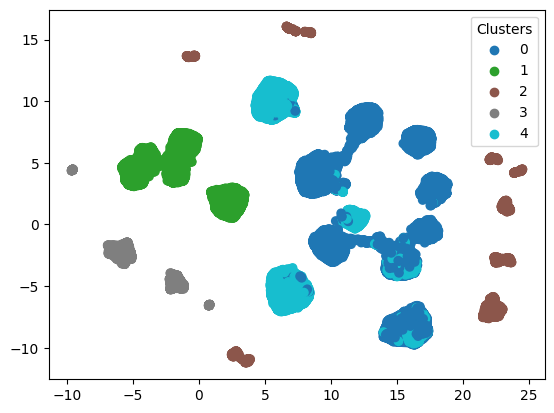

In [352]:
visualize_dimensionality_reduction(umap_embedding_mm, data['hc_d5_w5'])